In [24]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Running Torch {torch.__version__} with torchvision {torchvision.__version__} on device {device}')

Running Torch 2.4.1+cu121 with torchvision 0.19.1+cu121 on device cuda


In [7]:

train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=ToTensor(), target_transform=None)
test_dataset = datasets.FashionMNIST('./data', download=True, train=False, transform=ToTensor(), target_transform=None)

100%|██████████| 26421880/26421880 [00:02<00:00, 11090996.97it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1045538.39it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3971142.10it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3241110.33it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [18]:
img, label = train_dataset[0]

Text(0.5, 1.0, '9')

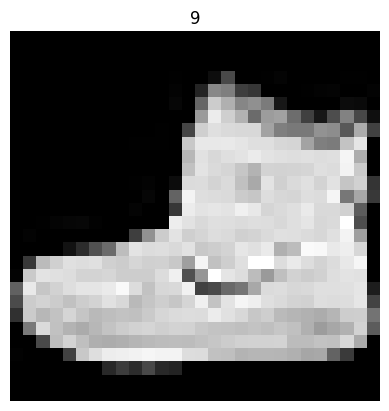

In [23]:
plt.imshow(torch.squeeze(img), cmap='gray')
plt.grid(False)
plt.axis(False)
plt.title(label)

In [25]:
# creating mini-batches
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# class names
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [38]:
img, label = next(iter(train_dataloader))
img.shape #[32, 1, 28, 28] batch, color, height, width

torch.Size([32, 1, 28, 28])

In [59]:
class ModelV0(nn.Module):
    def __init__(self, in_shape: int, hidden: int, out_shape: int):
        super().__init__()
        # fist convolutional block
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # second convolutional block
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # by default stride will equal to kernel size
        )
        # classifier block
        self.c1 = nn.Sequential(
            nn.Flatten(), # [32, 10*7*7]
            nn.Linear(in_features=hidden*7*7, out_features=out_shape) # 7*7 because of the flatten layer
        )

    def forward(self, x):
        x = self.b1(x) # [32, 10, 14, 14])
        x = self.b2(x) # [32, 10, 7, 7]
        x = self.c1(x)
        return x

        

In [60]:
model = ModelV0(in_shape=1, hidden=10, out_shape=len(class_names)).to(device)

In [61]:
images = torch.randn(size=(32, 3, 64, 64))
# images batch shape: [32, 3, 64, 64]
# image shape: [3, 64, 64]

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)

In [63]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [65]:
from tqdm import tqdm


epochs = 3

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = 0, 0

    model.to(device)
    model.train()

    # iterating through batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = criterion(y_pred, y) # prediciton, target
        train_loss += loss
        train_acc += accuracy(y_pred.argmax(dim=1), y) # argmax: logits -> pred labels

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}')

    test_loss, test_acc = 0, 0
    
    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += criterion(test_pred, y)
            test_acc += accuracy(test_pred.argmax(dim=1), y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f'Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.3480 | Train accuracy: 87.4733


 33%|███▎      | 1/3 [00:21<00:43, 21.76s/it]

Test loss: 0.3486 | Test accuracy: 87.5899
Train loss: 0.3053 | Train accuracy: 88.9933


 67%|██████▋   | 2/3 [00:44<00:22, 22.15s/it]

Test loss: 0.3131 | Test accuracy: 88.7879
Train loss: 0.2858 | Train accuracy: 89.7750


100%|██████████| 3/3 [01:06<00:00, 22.15s/it]

Test loss: 0.3091 | Test accuracy: 89.0276


In [67]:
torch.save(model, './model.pt')